In [38]:
%matplotlib inline
import os
import sys
from os.path import dirname

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import pickle
import glob
import matplotlib.patches as mpatches
import gdal
import georasters as gr
import geopandas as gp
import multiprocessing as mp
def gamma_porp(a,b):
    from scipy import special
    return special.gamma(a)-special.gamma(a)*special.gammainc(a,b)


/Users/daviddralle/anaconda2/envs/gr3/lib/python3.5/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/Users/daviddralle/anaconda2/envs/gr3/lib/python3.5/site-packages/ipykernel_launcher.py:50: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


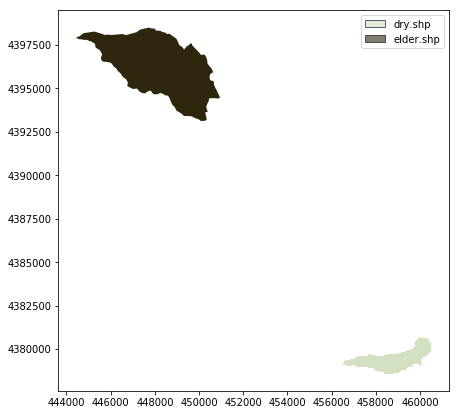

In [10]:
# get shapefiles 
filenames = glob.glob('./data/dry_elder/*.shp')

cols = sns.cubehelix_palette(n_colors=len((filenames)), rot=3)
f,ax = plt.subplots(figsize=(7,7))
hands = []
for i,f in enumerate(filenames):
    p = gp.read_file(f)
    geo = p.loc[p.geometry.area==p.geometry.area.max()]
    label = f.split('/')[-1]
    patch = mpatches.Patch(edgecolor='k', facecolor= cols[i], alpha=0.6, label=label)
    hands.append(patch)
    geo.plot(ax=ax, color=cols[i], label='_nolegend_')

plt.legend(handles=hands)


# empty list for dataframes generated by zonal stats
df_list = []
wy_total = {}

for i, f in enumerate(filenames):
    p = gp.read_file(f)
    name = f.split('/')[-1]
    geo = p.loc[p.geometry.area==p.geometry.area.max()].geometry.values[0]
    months = []
    et = []
    years = []
    for year in range(2001,2017):
        for month in range(1,13):
            months.append(month)
            years.append(year)
            year = str(year)
            month = str(month)
            if len(month)==1:
                month = '0'+ month
            
            rasterstring = "../../bess_v2/monthly_ET/ET_%s-%s.tif"%(month,year)
            rast = gr.from_file(rasterstring)
            clipped_rast = rast.clip(geo)[0]
            clipped_rast.nodata_value = None
            et.append(clipped_rast.mean())
    tempdf = pd.DataFrame({'Monthly ET [mm]':et,'watershed':name, 'month':months, 'year':years})
    tempdf['Monthly ET [mm]'] = tempdf['Monthly ET [mm]'].astype(float)
    df_list.append(tempdf.copy())

df = pd.concat(df_list,axis=0)
df['date'] = ''
for i, row in df.iterrows():
    df.ix[i, 'date'] = pd.to_datetime(str(row.month) + '-' + str(row.year))
df = df.set_index('date')


In [12]:
wsheds = list(set(df.watershed))
df['year'] = df['year'].astype(int)
df['month'] = df['month'].astype(int)
for wshed in wsheds:
    tempdf = df[['Monthly ET [mm]', 'month', 'year']].loc[(df.watershed==wshed)]
    summerets = []
    for g in tempdf.groupby('year'):
        summerdf = g[1]
        summerets.append(summerdf['Monthly ET [mm]'][(summerdf.month>=6)&(summerdf.month<=9)].sum())
    
    print('CV = %.3f, mean = %.2f'%(np.std(summerets)/np.mean(summerets), np.mean(summerets)))

CV = 0.047, mean = 497.11
CV = 0.086, mean = 326.13


In [17]:
def intercept_rain(ppt, interception_depth):
    freq = ppt.index.freq
    idx = ppt.index.copy()
    prcp = ppt.copy()
    precip_pre = ppt.ppt.resample('D').mean()+1e-12
    precip_post = precip_pre.apply(lambda x: np.max([0,x-interception_depth])) 
    rng = pd.date_range(precip_post.index[0], precip_post.index[-1], freq=freq)
    daily_multiplication_factor = precip_post/precip_pre
    daily_multiplication_factor = pd.DataFrame({'factor':daily_multiplication_factor.resample(freq).ffill().tolist()},index=rng)
    ppt.ppt = daily_multiplication_factor.factor*prcp.ppt
    return ppt

def run_chunk(arguments):
    LAM, W0, alpha, dt, tw, pet, num_sims, cpu = arguments        
    t = np.linspace(0,tw,int(np.ceil(tw/dt)))
    CV = np.zeros_like(LAM)
    for i in range(np.shape(LAM)[0]):
        for j in range(np.shape(LAM)[1]):
            lam, w0 = LAM[i,j], W0[i,j]
            S = np.zeros((num_sims, len(t)))
            for num in range(num_sims): 
                rainfall = np.array([np.random.exponential(alpha) if np.random.uniform() > np.exp(-lam*dt) else 0.0 for i in range(len(t))])
                x = np.zeros_like(rainfall)
                for idx in range(len(rainfall)-1):
                    dx = rainfall[idx]/w0 - pet*x[idx]*dt/w0
                    x[idx+1] = x[idx] + dx
                    x[idx+1] = np.min([x[idx+1], 1])
                s = x*w0
                S[num,:] = s
            CV[i,j] = np.std(S[:,-1])/np.mean(S[:,-1])
    return (CV, cpu)

def zero_runs(a):
    # Create an array that is 1 where a is 0, and pad each end with an extra 0.
    iszero = np.concatenate(([0], np.equal(a, 0).view(np.int8), [0]))
    absdiff = np.abs(np.diff(iszero))
    # Runs start and end where absdiff is 1.
    ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
    return ranges

In [29]:
rainfall = 10*pd.read_pickle('./data/elder_ppt.p') # it's stored in cm, convert mm
rainfall = intercept_rain(rainfall, 4.0)
wet_season = rainfall[(rainfall.index.month>=11)|(rainfall.index.month<=4)].ppt.ffill().values
lam = len(wet_season[wet_season>0])/float(len(wet_season))
alpha = np.mean(wet_season[wet_season>0])

runs = zero_runs(wet_season<=0)
lam_clustered = len(runs)/float(len(wet_season))
alpha_clustered = np.nanmean(np.array( [np.sum(wet_season[idx[0]:idx[1]]) for idx in runs]))

lam = lam_clustered
alpha = alpha_clustered
print('Rainfall frequency = %.3f per day, mean event depth = %.3f mm'%(lam, alpha))

Rainfall frequency = 0.124 per day, mean event depth = 61.985 mm


There are 4 cores


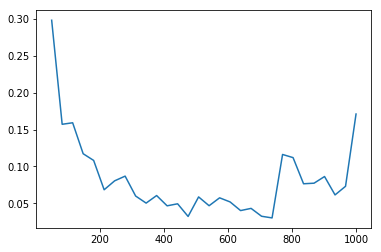

In [54]:
cores = mp.cpu_count()
sys.stdout.write('There are %s cores'%(cores) + '\r\n')
tw = 180.0 # wet season length in days
pet = 2.0  # pet during wet season (mm/day)
dt = 0.1
alpha = 60.0
num_sims = 10000
W0 = np.linspace(50, 1000, 30)
# LAM = np.linspace(1/30., 8/30.0, 1)
LAM = np.linspace(0.124, 0.124, 1)
X,Y = np.meshgrid(LAM, W0)
Xs, Ys = np.array_split(X,cores), np.array_split(Y, cores)
args = [(Xs[i], Ys[i], alpha, dt, tw, pet, num_sims, range(cores)[i]) for i in range(len(Xs))]
pool = mp.Pool()
results = pool.map(run_chunk, args)
CVS_list = [0 for i in range(len(Xs))]
for result in results:
     CVS_list[result[1]] = result[0]

pool.close()
pool.terminate()
CVS = np.concatenate(CVS_list)
if np.shape(X)[1]==1:
    y = Y.flatten()
    cvs = CVS.flatten()
    plt.plot(y, cvs)
else:
    plt.contourf(X,Y,CVS)
    plt.xlabel('Storm frequency [events per day]')
    plt.ylabel('Storage capacity [mm]')
    plt.title('Dry season storage sensitivity\nto climate and storage capacity')
    cb = plt.colorbar()
    cb.set_label('CV conditions @ dry season start ')

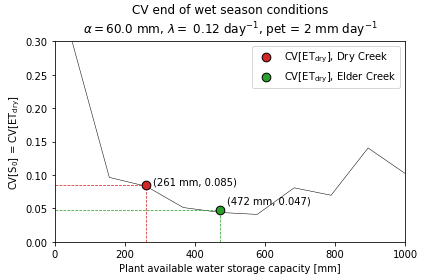

In [53]:
drymax= 0.085
eldermax = 0.047

drymax_storage = W0[np.argmin(np.abs(cvs[0:12] - drymax))]
eldermax_storage = W0[np.argmin(np.abs(cvs[0:-1] - eldermax))]

f,ax = plt.subplots(1,figsize=(6,4))
fun = scipy.interpolate.interp1d(W0, cvs,kind='cubic')
ax.plot(W0,fun(W0), 'k', lw=0.5)
plt.scatter(drymax_storage, drymax, c='C3', s=75, zorder=10, label='CV[ET$_\mathrm{dry}$], Dry Creek', edgecolors='k')
plt.scatter(eldermax_storage, eldermax, c='C2', s=75, zorder=10, label='CV[ET$_\mathrm{dry}$], Elder Creek',edgecolors='k')
plt.plot([0,eldermax_storage], [eldermax, eldermax],'--', c='C2', lw=0.75)
plt.plot([eldermax_storage,eldermax_storage], [0, eldermax],'--', c='C2', lw=0.75)
plt.plot([0,drymax_storage], [drymax, drymax],'--', c='C3', lw=0.75)
plt.plot([drymax_storage,drymax_storage], [0, drymax],'--', c='C3', lw=0.75)



plt.annotate('(%.0f mm, %.3f)'%(drymax_storage, drymax), (drymax_storage+20, drymax))
plt.annotate('(%.0f mm, %.3f)'%(eldermax_storage, eldermax), (eldermax_storage+20, eldermax+.01))

ax.set_xlabel('Plant available water storage capacity [mm]')
ax.set_ylabel('CV[S$_0$] = CV[ET$_\mathrm{dry}$]')
titlestr = 'CV end of wet season conditions\n'
titlestr += r'$\alpha = $'
titlestr += '%.1f mm, $\lambda = $ %.2f day$^{-1}$, pet = 2 mm day$^{-1}$'%(alpha, lam)
ax.set_title(titlestr)
ax.set_ylim([0,0.3])
ax.set_xlim([0,1000])


plt.legend()
plt.tight_layout()
plt.savefig('./plots/cv_end_mc_elderppt_ETdryseason.pdf')